In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import random
#import helper functions

torch.__version__
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(128)
torch.cuda.is_available()

True

In [15]:
def crop_my_image(image=0):
    # !THis worked really poorly
    #! This makes training take longer

    random_n = lambda a=0,b=1 : random.uniform(a,b) #*Change 0,1 to see extremes


    angle = random_n(-30, 30)
    shear = random_n(-15,15)
    scale = random_n(0.4,1.5)
    x = -((scale-0.5)*11-11)*random_n(0.5) #9 0
    y = -((scale-0.5)*11-11)*random_n(0.5) #9 0
    x = -x if random_n() > 0.5 else x #random flip +/-
    y = -y if random_n() > 0.5 else y #random flip +/-

    # print(f"Angle: {angle}")
    # print(f"Shear: {shear}")
    # print(f"Scale: {scale}")
    # print(f"x: {x}")
    # print(f"y: {y}")
    image = transforms.functional.affine(image,angle=angle, translate=(x,y),scale=scale, shear=shear)
    # image = randomness(image)
    # sized_up = transforms.functional.resized_crop(image, int(size/2),int(size/2),28-size,28-size,28).mul(1.65)

    return image

custom_transform = transforms.Compose([ToTensor(), crop_my_image]) #Model 3


In [2]:
#Visualising data
# Download the dataset first
train_data = datasets.MNIST("~/data", train=True, download=True, )
test_data = datasets.MNIST("~/data", train=False, download=True, )

# custom_transform = transforms.Compose([ToTensor(),transforms.RandomResizedCrop(size=28, scale=(0.5, 1.0), ratio=(1.0, 1.0))]) # Model 2
custom_transform = transforms.Compose([ToTensor(),transforms.RandomAffine(degrees=10, translate=(0.4,0.4), scale=(0.25, 1.25))]) #Model 3
# custom_transform = transforms.Compose([ToTensor()]) #Model 3.1

train_loader = DataLoader(
        datasets.MNIST("./data", train=True, download=True, transform=custom_transform,),
        batch_size=128,
        shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(
        datasets.MNIST("./data", train=False, download=True, transform=custom_transform,),
        batch_size=128,
        shuffle=False, num_workers=4, pin_memory=True)


In [4]:
img, label = images[5].squeeze(), labels[5].item()
plt.title(label)
plt.imshow(img, cmap="gray")

plt.title("Original")
plt.imshow(img, cmap="gray")
   

images.shape

NameError: name 'images' is not defined

In [3]:
#! Unable to 
#Familier model, best 98.69% epoch 6
#nn.CrossEntropyLoss(),
#optim.Adam(params=model_0.parameters(), lr=0.001, weight_decay=0.001),

class digit_classifier(nn.Module):
  def __init__(self, hidden=10):
    super(digit_classifier, self).__init__()

    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=hidden, kernel_size=3, stride=1, padding=1),#28
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1, padding=1),#28
        nn.LeakyReLU(),
        #Don't work with onnx?
        nn.MaxPool2d(kernel_size=2, stride=2)#14/2
    )
    self.block_2 = nn.Sequential(
        nn.Conv2d(hidden, hidden, kernel_size=3, stride=1, padding=1),#14
        nn.LeakyReLU(),
        nn.Conv2d(hidden, hidden, kernel_size=3, stride=1, padding=1),#14
        nn.LeakyReLU(),
        #Don't work with onnx?
         nn.MaxPool2d(kernel_size=2, stride=2)#14/2

       
    )
    self.output = nn.Sequential(
        nn.Flatten(),
        nn.Linear(hidden*7*7, len(train_data.classes))
    )
  def forward(self, x):
    x = self.block_1(x)
    x = self.block_2(x)
    x =  self.output(x)
    #! Don't use softmax, stabilty reason? 
    return x
model_0 = digit_classifier(20).to(device) #Only one input channel

In [4]:
class digit_classifier_1(nn.Module):
  def __init__(self, hidden=10):
    super(digit_classifier_1, self).__init__()

    self.block_1 = nn.Sequential(
        nn.BatchNorm2d(1),
        nn.Conv2d(in_channels=1, out_channels=hidden, kernel_size=3, stride=1, padding=1),#28
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1, padding=1),#28
        nn.LeakyReLU(),
        #Don't work with onnx?
        nn.MaxPool2d(kernel_size=2, stride=2),#14/2
    )
    self.block_2 = nn.Sequential(
        nn.BatchNorm2d(hidden),
        nn.Conv2d(hidden, hidden, kernel_size=3, stride=1, padding=1),#14
        nn.LeakyReLU(),
        nn.Conv2d(hidden, hidden, kernel_size=3, stride=1, padding=1),#14
        nn.LeakyReLU(),
        #Don't work with onnx?
         nn.MaxPool2d(kernel_size=2, stride=2), #14/2

    )
    self.output = nn.Sequential(
        nn.Flatten(),
        nn.Linear(hidden*7*7, hidden*7*7),
        nn.Linear(hidden*7*7, len(train_data.classes)),
    )
  def forward(self, x):
    x = self.block_1(x)
    x = self.block_2(x)
    x =  self.output(x)
    return x
model_1 = digit_classifier_1(20).to(device)
net = nn.DataParallel(model_1)

In [5]:
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optim: torch.optim,
               device: torch.device,
               print_output:bool=True):
    model.train()
    train_loss, train_acc = 0, 0
    for (X, y) in dataloader :#tqdm inside enumrater

        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_acc += accuracy_fn(y_pred.argmax(dim=1), y)
        train_loss += loss # ?.item()

        optim.zero_grad()

        loss.backward()

        optim.step()

    train_acc /= len(dataloader)
    train_loss /= len(dataloader)

    if print_output: print(f"train: {train_loss}, {train_acc}%")  
    return [train_loss.item(), train_acc]

def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device,
               print_output:bool=True):
    ##Testing
    test_loss, test_acc = 0, 0

    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            if test_loss == 0:
                plt.imshow(X[0].squeeze())
                plt.title(y[0].item())
                plt.show()
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch
            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(test_pred.argmax(dim=1), y)
    
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
    if print_output: print(f"test: {test_loss}, {test_acc}%")
    return test_acc



Epoch 1
--------
train: 0.2884136736392975, 90.89430081734187%


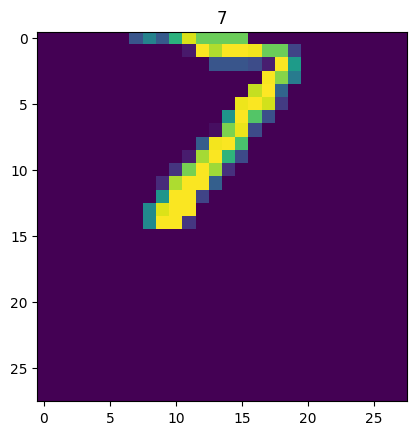

test: 0.27360963821411133, 91.07990506329114%
Epoch 2
--------
train: 0.2982966899871826, 90.6383262260128%


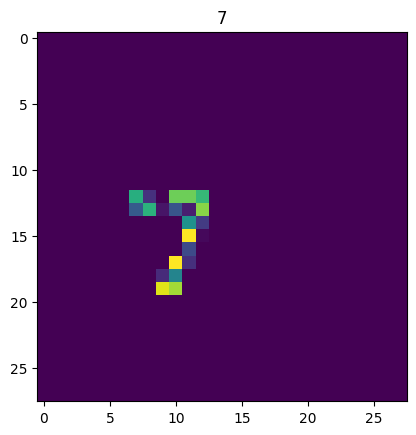

test: 0.267403781414032, 91.56447784810126%
Epoch 3
--------
train: 0.29155680537223816, 90.79157782515992%


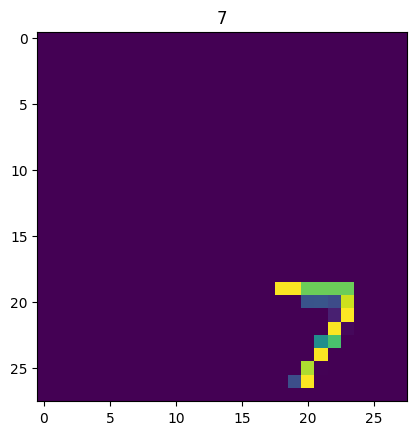

test: 0.26897454261779785, 91.54469936708861%
Epoch 4
--------
train: 0.29180145263671875, 90.86376154939587%


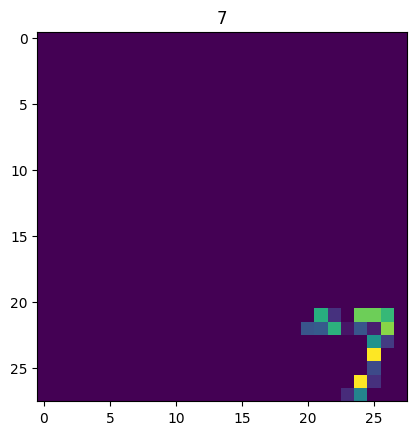

test: 0.26821693778038025, 91.3370253164557%


In [14]:
epochs = 4

model_1.to(device)
#? Scedchuler
for epoch in range(epochs):
  print(f"Epoch {epoch+1}\n--------")
  train_step(model_1, train_loader,
           nn.CrossEntropyLoss(),
           optim.SGD(params=model_1.parameters(), lr=0.00001),
           device)

  test_step(model_1, test_loader,
           nn.CrossEntropyLoss(),
           device)
        
        

In [15]:
#Making some predictions
model_1.to(device="cpu")
x = torch.zeros(1,1,28,28)
model_1.eval()

torch.onnx.export(model_1,             
                  x,                   
                  "model_4.onnx",   
                  opset_version=9,     
                  verbose=True,       
                  )


x.shape

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



torch.Size([1, 1, 28, 28])